In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


# Lectura de datos

In [2]:
df_base = pd.read_csv(r'..\data\raw\base_train.csv',sep='|', encoding='utf-8')
df_base.head()

,num_doc,f_analisis,default,tipo_cliente,trx39,trx102,trx106,trx143,trx158,disp309,...,CO01END086RO,CO01END094RO,CO02NUM086AH,CO02NUM043RO,CO01EXP002AH,CO01NUM002AH,CO01END051RO,CO01ACP011RO,CO02MOR092TO,CO01MOR098RO
0,7.283207e+08,201810,0,adicion,1.213352,0.000000,0.000000,0.000000,0.242403,8.0,...,28.24,3.20,28.57,33.33,10.0,2.0,0.99,1.0,100.0,-3.00000
1,1.242291e+10,201801,1,adicion,0.000000,0.000000,0.000001,0.000000,0.000000,8.0,...,-1.00,-1.00,60.00,-1.00,4.0,3.0,-1.00,-1.0,0.0,-1.00000
2,3.419426e+10,201803,0,adicion,0.953794,0.000000,0.000000,0.404773,0.203330,11.0,...,14.56,20.48,75.00,90.91,15.0,3.0,1.50,0.0,100.0,100.00000
3,3.601473e+10,201807,0,adicion,2.236068,0.000010,0.000003,0.424556,1.227298,8.0,...,-3.00,0.38,28.57,0.00,8.0,2.0,-4.00,-2.0,-3.0,-2.00000
4,5.051837e+10,201811,0,adicion,2.361438,0.000001,0.000023,0.000000,0.392063,0.0,...,74.66,32.00,33.33,81.82,16.0,2.0,0.00,3.0,100.0,89.22658


In [3]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28276 entries, 0 to 28275
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_doc       28276 non-null  float64
 1   f_analisis    28276 non-null  int64  
 2   default       28276 non-null  int64  
 3   tipo_cliente  28276 non-null  object 
 4   trx39         28276 non-null  float64
 5   trx102        28276 non-null  float64
 6   trx106        28276 non-null  float64
 7   trx143        28276 non-null  float64
 8   trx158        28276 non-null  float64
 9   disp309       28276 non-null  float64
 10  CO01END010RO  28276 non-null  float64
 11  CO01ACP017CC  28276 non-null  float64
 12  CO02EXP011TO  28276 non-null  float64
 13  CO02EXP004TO  28276 non-null  float64
 14  CO01EXP001CC  28276 non-null  float64
 15  CO01EXP003RO  28276 non-null  float64
 16  CO02END015CC  28276 non-null  float64
 17  CO01END002RO  28276 non-null  float64
 18  CO01END086RO  28276 non-nu

# Limpieza de la informacion

## Limpieza profunda de las variables

In [4]:
df = df_base.copy()
df.drop(columns=['num_doc','f_analisis'], inplace=True)

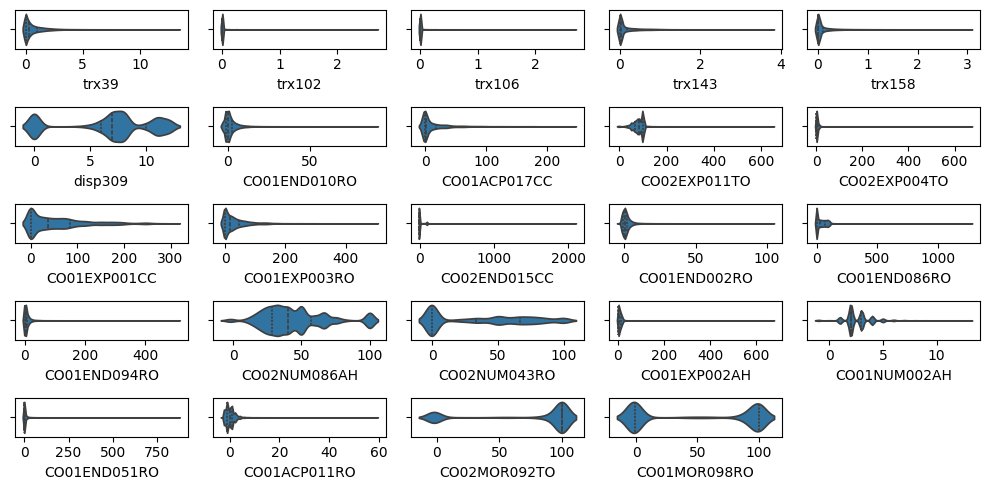

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = df.select_dtypes(include=['float64', 'int64']).drop(columns=['default']).columns

# Boxplots para detectar outliers por variable
plt.figure(figsize=(10,5))
for i, col in enumerate(numeric_cols[:25]):  # puedes ajustar el rango
    plt.subplot(5, 5, i + 1)
    sns.violinplot(x=df[col], inner='quartile')
plt.tight_layout()
plt.show()




reconversion de variables numericas a categoricas

In [6]:
# 1. CO01MOR098RO – Cumplimiento Rotativo últimos 24 meses
df['CO01MOR098RO'] = pd.cut(df['CO01MOR098RO'], 
                                bins=[-0.01, 25, 75, 100], 
                                labels=['bajo', 'medio', 'alto'])
# Esta variable presenta una distribución polarizada que representa mejor el riesgo cuando se agrupa por niveles de cumplimiento.

# 2. CO02MOR092TO – Cumplimiento Total últimos 18 meses
df['CO02MOR092TO'] = pd.cut(df['CO02MOR092TO'], 
                                bins=[-0.01, 25, 75, 100], 
                                labels=['bajo', 'medio', 'alto'])
# Dado su comportamiento extremo y poco continuo, agrupar este score mejora la estabilidad del modelo y su interpretación.

# 3. disp309 – Versión de SO móvil
df['disp309'] = pd.cut(df['disp309'], 
                           bins=[0, 5, 9, 20], 
                           labels=['bajo', 'medio', 'alto'])
# La versión del sistema operativo refleja un nivel digital y económico que es mejor tratado como variable ordinal categórica.

# 4. CO01NUM002AH – Número de cuentas de ahorro
df['CO01NUM002AH'] = pd.cut(df['CO01NUM002AH'], 
                                bins=[-0.01, 0, 2, 5, 20], 
                                labels=['sin_ahorro', 'bajo', 'medio', 'alto'])
# Agrupar el número de productos de ahorro permite identificar niveles de bancarización con mayor valor explicativo.

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28276 entries, 0 to 28275
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   default       28276 non-null  int64   
 1   tipo_cliente  28276 non-null  object  
 2   trx39         28276 non-null  float64 
 3   trx102        28276 non-null  float64 
 4   trx106        28276 non-null  float64 
 5   trx143        28276 non-null  float64 
 6   trx158        28276 non-null  float64 
 7   disp309       22274 non-null  category
 8   CO01END010RO  28276 non-null  float64 
 9   CO01ACP017CC  28276 non-null  float64 
 10  CO02EXP011TO  28276 non-null  float64 
 11  CO02EXP004TO  28276 non-null  float64 
 12  CO01EXP001CC  28276 non-null  float64 
 13  CO01EXP003RO  28276 non-null  float64 
 14  CO02END015CC  28276 non-null  float64 
 15  CO01END002RO  28276 non-null  float64 
 16  CO01END086RO  28276 non-null  float64 
 17  CO01END094RO  28276 non-null  float64 
 18  CO02NU

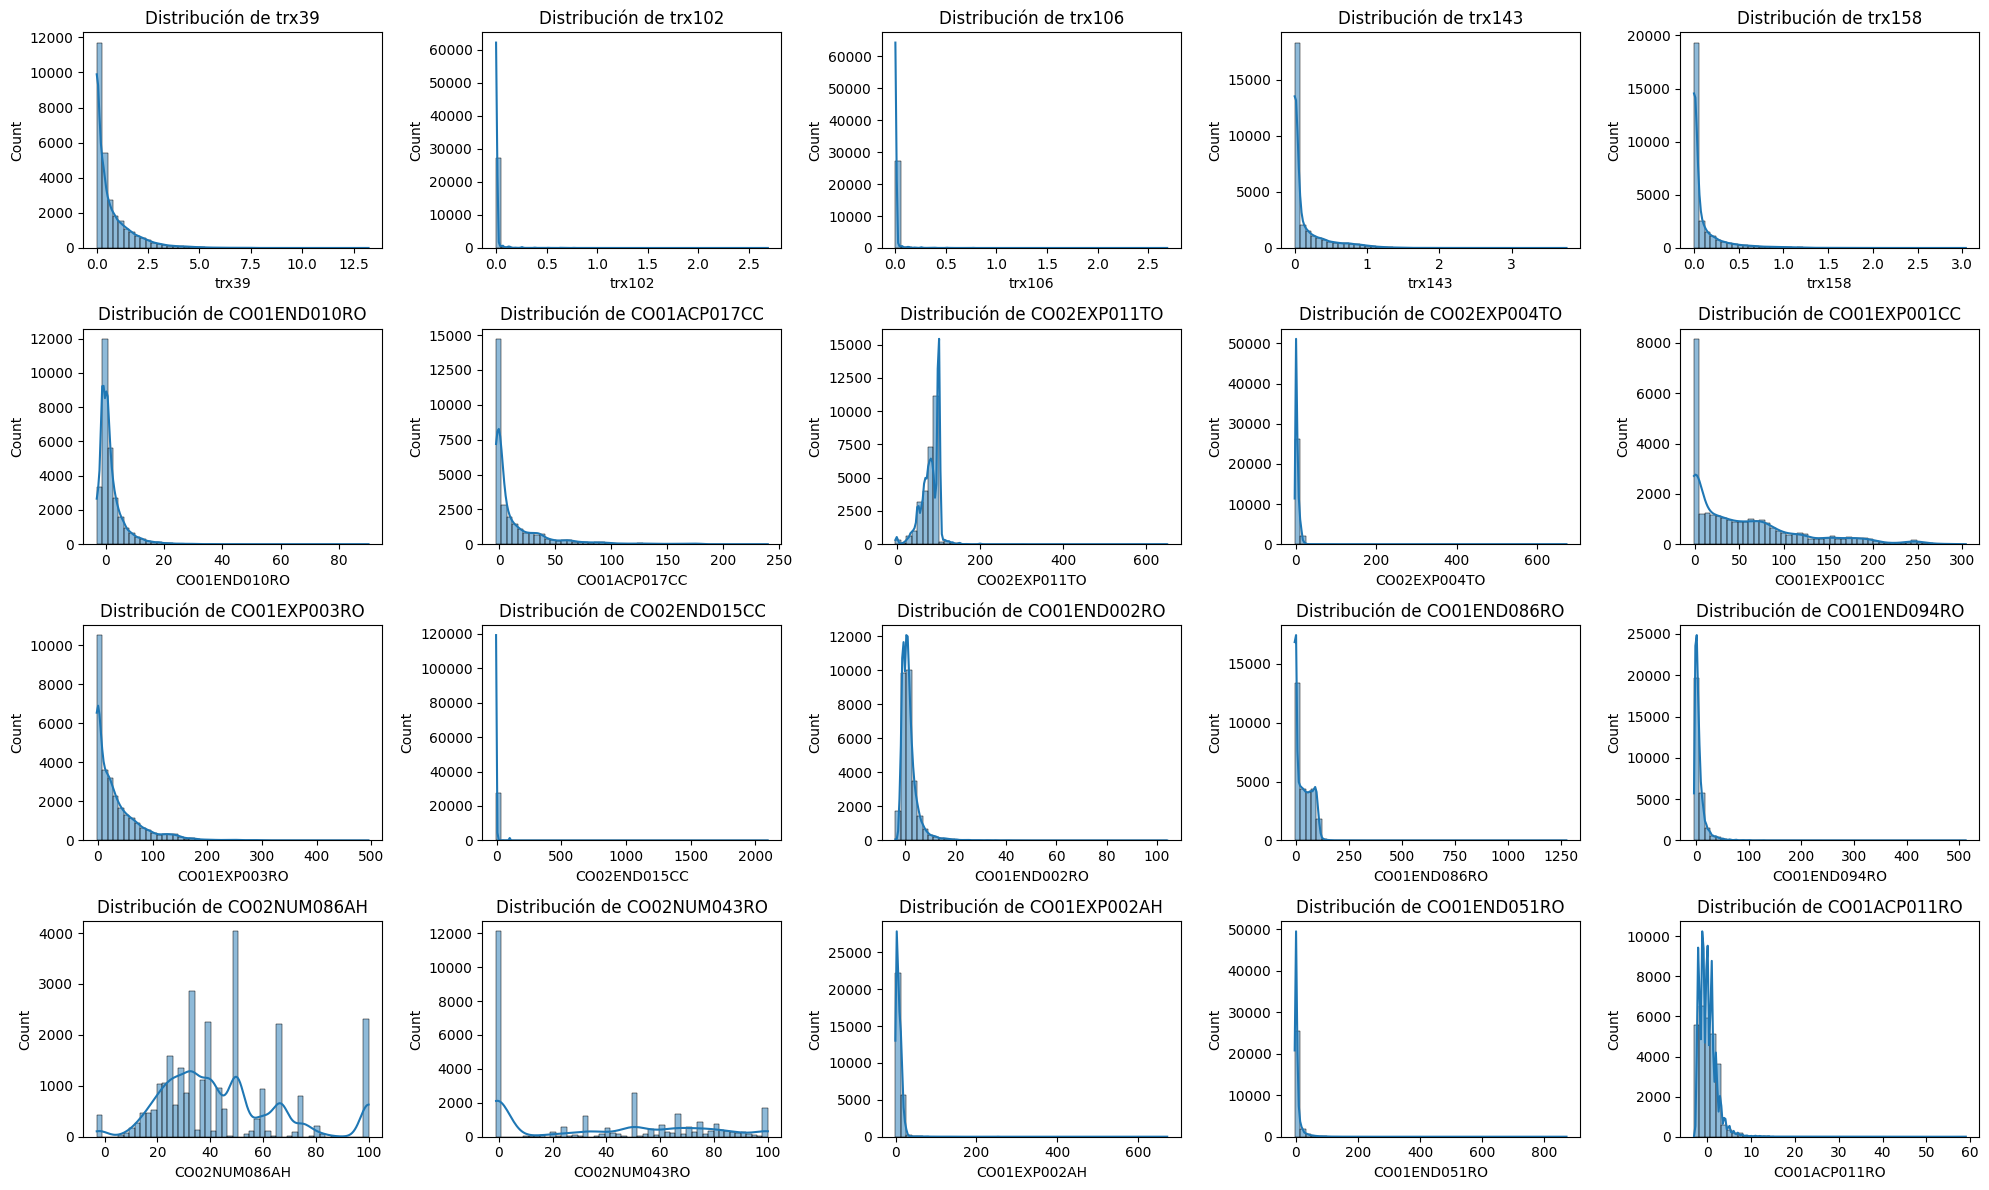

Variables con alta asimetría: ['CO02END015CC', 'CO02EXP004TO', 'CO01EXP002AH', 'trx102', 'trx106', 'CO01END051RO', 'CO01END094RO', 'CO01END002RO', 'CO01ACP011RO', 'trx158', 'CO01END010RO', 'CO01ACP017CC', 'CO01END086RO', 'trx143', 'trx39', 'CO01EXP003RO', 'CO01EXP001CC']
Cantidad de variables con alta asimetría: 17 de un total de 20


In [ ]:
numeric_cols_v2 = df.select_dtypes(include=['float64', 'int64']).drop(columns=['default']).columns


num_plots = len(numeric_cols_v2[:25])
ncols = 5
nrows = (num_plots + ncols - 1) // ncols  

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 3))
axes = axes.flatten()

# Histograma de distribución (para detectar sesgo positivo)
for ax, col in zip(axes, numeric_cols_v2[:25]):
    sns.histplot(df[col], kde=True, bins=50, ax=ax)
    ax.set_title(f'Distribución de {col}')

for ax in axes[num_plots:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

# Revisión de skewness (asimetría)
skewness = df[numeric_cols_v2].skew().sort_values(ascending=False)

# Identificar variables candidatas para log1p (log(1+x))
log_candidates = skewness[skewness > 1.0].index.tolist()
print("Variables con alta asimetría:", log_candidates)
print(f'Cantidad de variables con alta asimetría: {len(log_candidates)} de un total de {len(numeric_cols_v2)}')

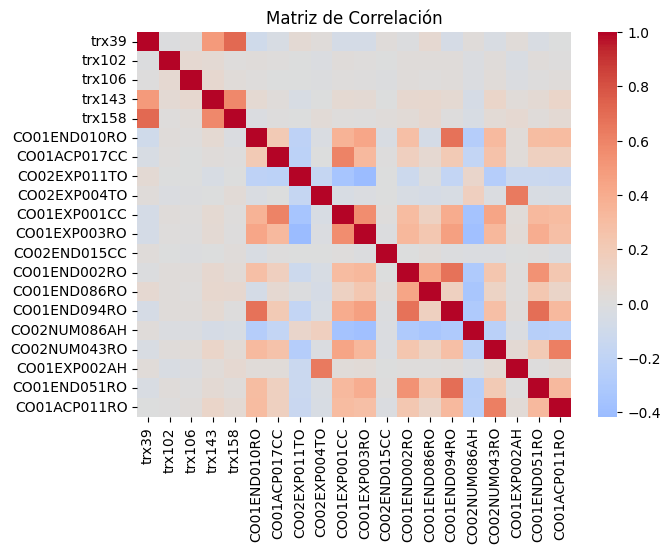

In [8]:
# Matriz de correlación
corr_matrix = df[numeric_cols_v2].corr()

# Visualización con mapa de calor
plt.figure(figsize=(7,5))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, center=0,) # nombre parametro para solo ver los valores de correlación : 
plt.title('Matriz de Correlación')
plt.show()


In [ ]:
corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
    .rename(columns={'level_0': 'var1', 'level_1': 'var2', 0: 'correlation'})
)
corr_pairs['abs_correlation'] = corr_pairs['correlation'].abs()

corr_pairs[corr_pairs['abs_correlation'] > 0.5].sort_values(by='abs_correlation', ascending=False).head(10)

,var1,var2,correlation,abs_correlation
3,trx39,trx158,0.712149,0.712149
178,CO01END094RO,CO01END051RO,0.691171,0.691171
163,CO01END002RO,CO01END094RO,0.670949,0.670949
93,CO01END010RO,CO01END094RO,0.670909,0.670909
132,CO02EXP004TO,CO01EXP002AH,0.640431,0.640431
186,CO02NUM043RO,CO01ACP011RO,0.622062,0.622062
101,CO01ACP017CC,CO01EXP001CC,0.603604,0.603604
54,trx143,trx158,0.579683,0.579683
135,CO01EXP001CC,CO01EXP003RO,0.552482,0.552482
167,CO01END002RO,CO01END051RO,0.538097,0.538097


### Limpieza outliers

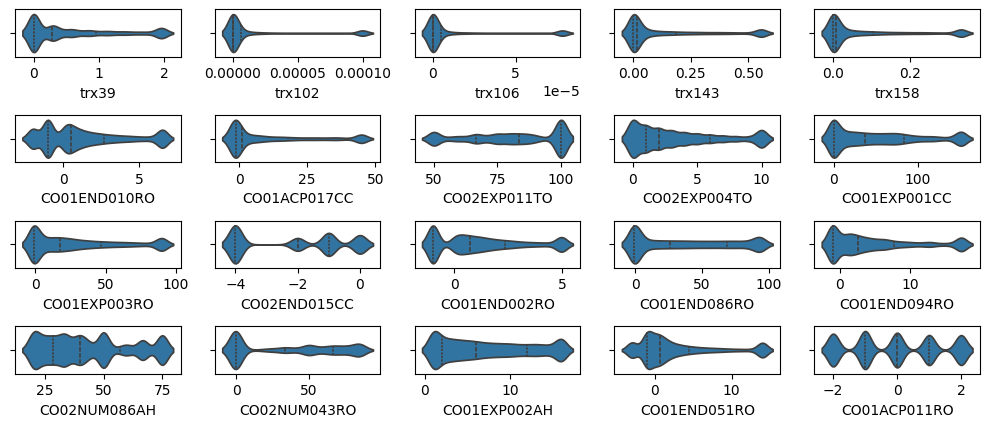

In [ ]:
def winsorize_series(s, lower=0.1, upper=0.9):
    lower_val = s.quantile(lower)
    upper_val = s.quantile(upper)
    return s.clip(lower=lower_val, upper=upper_val)

for col in numeric_cols_v2:
    df[col] = winsorize_series(df[col])

plt.figure(figsize=(10,5))
for i, col in enumerate(numeric_cols_v2[:25]):  
    plt.subplot(5, 5, i + 1)
    sns.violinplot(x=df[col], inner='quartile')
plt.tight_layout()
plt.show()

## Analisis de valores nulos y duplicados

In [11]:
df_limpio = df.copy()

print(f'Cantidad de valores duplicados: {df_limpio.duplicated().sum()}')
# Eliminar duplicados
df_limpio.drop_duplicates(inplace=True)
print(f'Cantidad de valores duplicados luego de eliminar: {df_limpio.duplicated().sum()}')

Cantidad de valores duplicados: 317
Cantidad de valores duplicados luego de eliminar: 0


In [13]:
df_limpio.isna().sum()

default             0
tipo_cliente        0
trx39               0
trx102              0
trx106              0
trx143              0
trx158              0
disp309          5842
CO01END010RO        0
CO01ACP017CC        0
CO02EXP011TO        0
CO02EXP004TO        0
CO01EXP001CC        0
CO01EXP003RO        0
CO02END015CC        0
CO01END002RO        0
CO01END086RO        0
CO01END094RO        0
CO02NUM086AH        0
CO02NUM043RO        0
CO01EXP002AH        0
CO01NUM002AH      308
CO01END051RO        0
CO01ACP011RO        0
CO02MOR092TO     5828
CO01MOR098RO    13029
dtype: int64

In [ ]:

# Calcular porcentaje de valores nulos por columna
porcentaje_nulos = round(df_limpio.isnull().mean(),4) * 100
porcentaje_nulos = porcentaje_nulos.reset_index()
porcentaje_nulos.columns = ['Columna', 'Porcentaje de Nulos']

fig = px.bar(porcentaje_nulos,
             x='Columna',
             y='Porcentaje de Nulos',
             title='Porcentaje de valores nulos por columna')

fig.update_layout(xaxis_tickangle=-90)

fig.show()


In [ ]:

categorical_with_nans = ['disp309', 'CO02MOR092TO', 'CO01MOR098RO']

for col in categorical_with_nans:
    if 'desconocido' not in df_limpio[col].cat.categories:
        df_limpio[col] = df_limpio[col].cat.add_categories('desconocido')
    df_limpio[col] = df_limpio[col].fillna('desconocido')

df_limpio['CO01NUM002AH'] = df_limpio['CO01NUM002AH'].fillna(df_limpio['CO01NUM002AH'].mode()[0])

print(f'Cantidad de valores nulos luego de imputar: {df_limpio.isnull().sum().sum()}')


Cantidad de valores nulos luego de imputar: 0


In [16]:
df_limpio.isna().sum()

default         0
tipo_cliente    0
trx39           0
trx102          0
trx106          0
trx143          0
trx158          0
disp309         0
CO01END010RO    0
CO01ACP017CC    0
CO02EXP011TO    0
CO02EXP004TO    0
CO01EXP001CC    0
CO01EXP003RO    0
CO02END015CC    0
CO01END002RO    0
CO01END086RO    0
CO01END094RO    0
CO02NUM086AH    0
CO02NUM043RO    0
CO01EXP002AH    0
CO01NUM002AH    0
CO01END051RO    0
CO01ACP011RO    0
CO02MOR092TO    0
CO01MOR098RO    0
dtype: int64